In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel, ViTConfig
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset and the output directories
dataset_dir = '/home/shubhankarm/Final_Project/PlantVillage-Dataset/raw/color'
train_dir = '/home/shubhankarm/Final_Project/PlantVillage-Dataset/train'
test_dir = '/home/shubhankarm/Final_Project/PlantVillage-Dataset/test'

# Step 1: Collect all image file paths and their labels (based on folder structure)
image_paths = []
labels = []

# Traverse through each subfolder in 'color' directory
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    # Check if it's a directory (each class is a folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            
            # Check if file is an image (you can add more extensions if needed)
            if os.path.isfile(file_path) and filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(file_path)
                labels.append(class_name)

# Step 2: Split the data into 80% train and 20% test (adjust as needed)
train_images, test_images = train_test_split(list(zip(image_paths, labels)), test_size=0.2, random_state=42)

# Step 3: Move files into the train and test directories
for dir_path in [train_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Step 4: Process the training set
for img_path, label in train_images:
    class_train_dir = os.path.join(train_dir, label)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)
    
    # Copy image to the respective class folder in the training set
    shutil.copy(img_path, class_train_dir)

# Step 5: Process the testing set
for img_path, label in test_images:
    class_test_dir = os.path.join(test_dir, label)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)
    
    # Copy image to the respective class folder in the testing set
    shutil.copy(img_path, class_test_dir)

print(f"Train set size: {len(train_images)} images")
print(f"Test set size: {len(test_images)} images")


Train set size: 43444 images
Test set size: 10861 images


In [3]:
train_path = '/home/shubhankarm/Final_Project/PlantVillage-Dataset/train'
valid_path = '/home/shubhankarm/Final_Project/PlantVillage-Dataset/test'

In [4]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
# Load datasets
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_path, transform=valid_transforms)

# Data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=8 , pin_memory= True)

In [16]:
num_classes = len(train_data.classes)
num_classes

38

In [17]:
# Configuration for ViT
config = ViTConfig.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTModel(config)

In [18]:
class CustomModel(nn.Module):
    def __init__(self, vit_model, num_classes):
        super(CustomModel, self).__init__()
        self.vit_model = vit_model
        self.fc = nn.Linear(config.hidden_size, num_classes)  # Output layer should match the number of classes

    def forward(self, x):
        outputs = self.vit_model(x).pooler_output
        x = self.fc(outputs)
        return x


In [19]:
model = CustomModel(vit_model,num_classes)

# Unfreeze the last few layers of the ViT model for fine-tuning
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.encoder.layer[-4:].parameters():
    param.requires_grad = True

In [20]:
# Move model to device (GPU if available)
device = torch.device("cuda")
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': vit_model.encoder.layer[-4:].parameters(), 'lr': 1e-5},
    {'params': model.fc.parameters(), 'lr': 1e-3}
])


In [21]:
# Training and validation
num_epochs = 20  # Increase the number of epochs
best_accuracy = 0.0
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

In [22]:
print(f"Device: {device}")


Device: cuda


In [24]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validate the model
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    valid_losses.append(running_val_loss / len(valid_loader))
    valid_accuracies.append(100 * correct_val / total_val)

    accuracy = 100 * correct_val / total_val
    print(
        f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}, Validation Loss: {valid_losses[-1]}, Train Accuracy: {train_accuracies[-1]}%, Validation Accuracy: {valid_accuracies[-1]}%")

    #Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')


Epoch 1, Train Loss: 1.9443150734602965, Validation Loss: 1.3575762834180805, Train Accuracy: 43.97154958106988%, Validation Accuracy: 59.08295737040788%
Epoch 2, Train Loss: 1.3609064634401071, Validation Loss: 1.1409095155979123, Train Accuracy: 58.601878280084705%, Validation Accuracy: 64.57048153945308%
Epoch 3, Train Loss: 1.0579208471374764, Validation Loss: 0.8818393567440045, Train Accuracy: 67.21986925697449%, Validation Accuracy: 72.12963815486603%
Epoch 4, Train Loss: 0.8525265585823157, Validation Loss: 0.7361767672331018, Train Accuracy: 73.24601786207532%, Validation Accuracy: 76.42021913267655%
Epoch 5, Train Loss: 0.7030082100642974, Validation Loss: 0.5606225975446731, Train Accuracy: 77.53429702605654%, Validation Accuracy: 81.78804898259828%
Epoch 6, Train Loss: 0.6028387899152572, Validation Loss: 0.4770070756511653, Train Accuracy: 80.71770555197496%, Validation Accuracy: 84.26480066292238%
Epoch 7, Train Loss: 0.5246177293601636, Validation Loss: 0.417253657641669

In [25]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_3079553/869501355.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

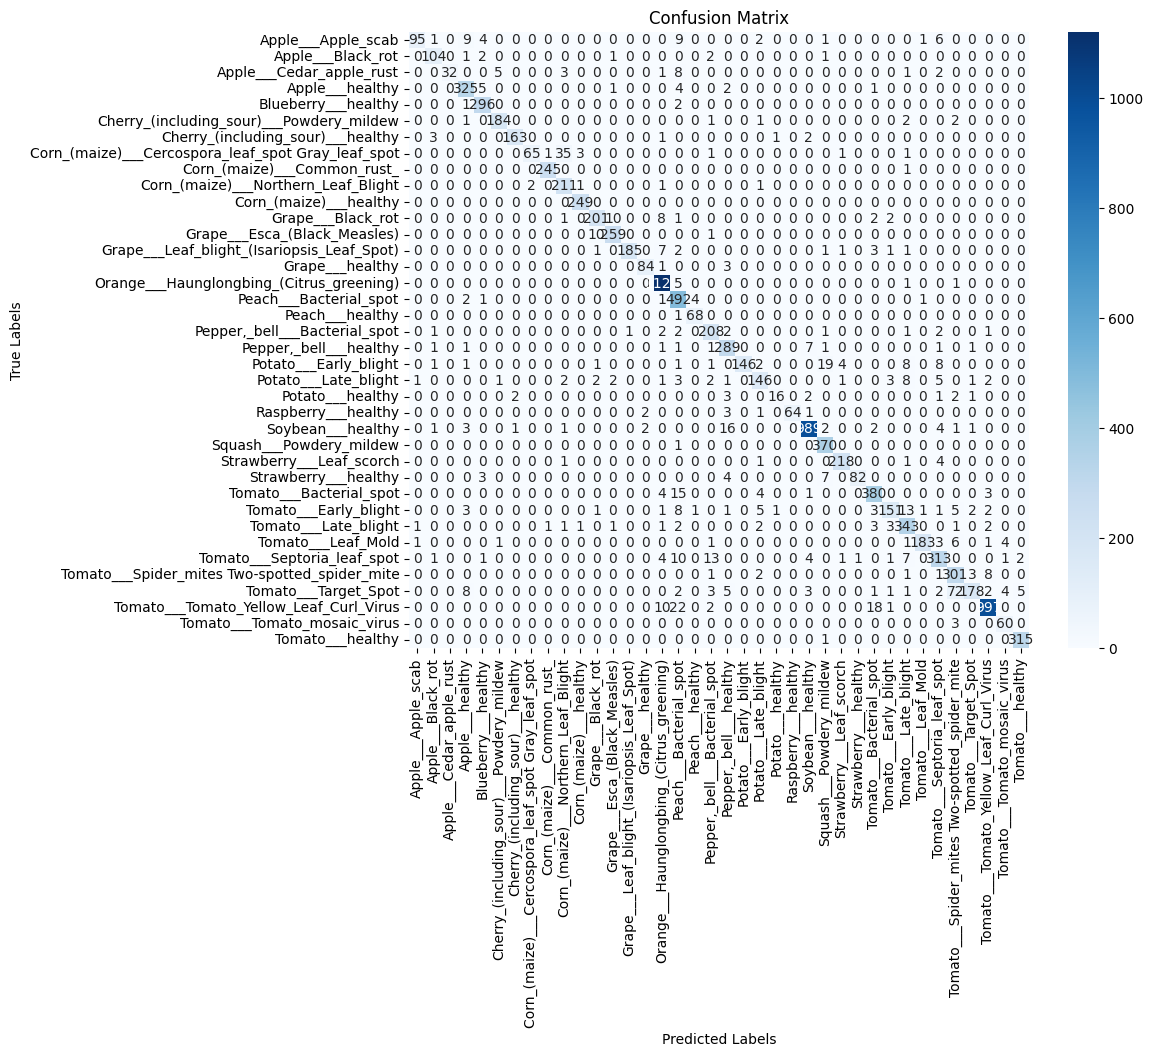

In [26]:
# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Print classification report
class_names = train_data.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.74      0.84       128
                                 Apple___Black_rot       0.92      0.94      0.93       111
                          Apple___Cedar_apple_rust       1.00      0.62      0.76        52
                                   Apple___healthy       0.92      0.96      0.94       338
                               Blueberry___healthy       0.95      0.99      0.97       299
          Cherry_(including_sour)___Powdery_mildew       0.96      0.96      0.96       191
                 Cherry_(including_sour)___healthy       0.98      0.96      0.97       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.61      0.75       107
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       246
               Corn_(maize)___Northern_Leaf_Blight       0.83      0.98      0.

In [28]:
# Compute overall accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {accuracy * 100}%')

Overall Accuracy: 93.24187459718259%


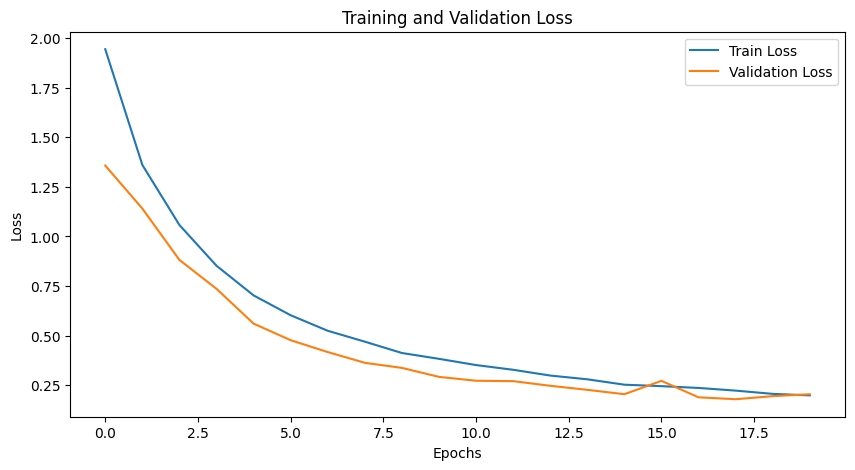

In [29]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

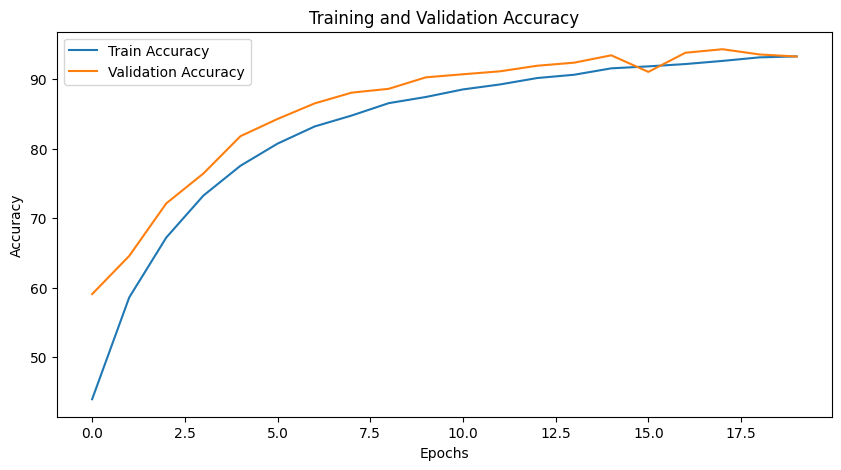

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(num_epochs), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Testing the model

In [31]:
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig

In [ ]:
class_names = [
    "Tomato___Bacterial_spot", "Tomato___Early_blight", "Tomato___Late_blight", 
    "Tomato___Leaf_Mold", "Tomato___Septoria_leaf_spot", 
    "Tomato___Spider_mites_Two-spotted_spider_mite", "Tomato___Target_Spot", 
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus", "Tomato___Tomato_mosaic_virus", 
    "Tomato___healthy"
]

In [32]:
# Load the trained model weights
model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))
model.eval()

/tmp/ipykernel_3079553/1382607961.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))


CustomModel(
  (vit_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_

In [38]:
# Data transformations for the test image
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [41]:
# Function to predict the disease type from an image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    image = test_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        class_name = class_names[predicted.item()]
    return class_name

In [44]:
def get_ground_truth(image_path):
    ground_truth = image_path.split('/')[-2]  # Get the folder name, which contains the disease type
    ground_truth = ground_truth.replace('___', '_')  # Replace '___' with '_'
    return ground_truth

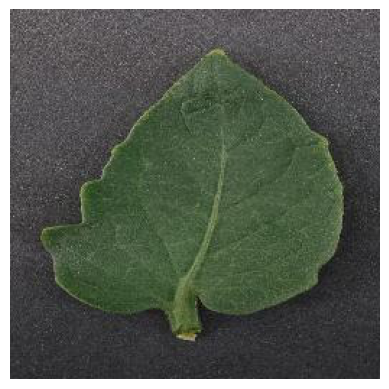

Ground Truth Disease: Tomato_healthy
Predicted Disease: Tomato___healthy


In [46]:
image_path = 'PlantVillage-Dataset/test/Tomato___healthy/0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1.JPG'
disease_type = predict_image(image_path)
ground_truth = get_ground_truth(image_path)
print(f'Ground Truth Disease: {ground_truth}')
print(f'Predicted Disease: {disease_type}')

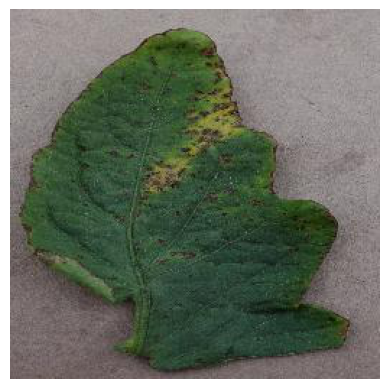

Ground Truth Disease: Tomato_Bacterial_spot
Predicted Disease: Tomato___Bacterial_spot


In [47]:
image_path = 'PlantVillage-Dataset/test/Tomato___Bacterial_spot/0cbaca0d-e422-438f-89df-344b493888b8___GCREC_Bact.Sp 5832.JPG'
ground_truth = get_ground_truth(image_path)
disease_type = predict_image(image_path)
print(f'Ground Truth Disease: {ground_truth}')
print(f'Predicted Disease: {disease_type}')